# Text Mining
### Install necessary packages and functions

In [3]:
from sklearn import metrics 
import numpy as np 
import pandas as pd 
import glob, os  
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
%run ./Text_Normalization_Function.ipynb
warnings.simplefilter(action='ignore')

Original:   <p>The circus dog in a plissé skirt jumped over Python who wasn't that large, just 3 feet long.</p>
Processed:  ['<', 'p', '>', 'The', 'circus', 'dog', 'in', 'a', 'plissé', 'skirt', 'jumped', 'over', 'Python', 'who', 'was', "n't", 'that', 'large', ',', 'just', '3', 'feet', 'long.', '<', '/p', '>']
Original:   <p>The circus dog in a plissé skirt jumped over Python who wasn't that large, just 3 feet long.</p>
Processed:  <p>The circus dog in a plissé skirt jumped over Python who was not that large, just 3 feet long.</p>
Original:   <p>The circus dog in a plissé skirt jumped over Python who wasn't that large, just 3 feet long.</p>
Processed:  [('<', 'a'), ('p', 'n'), ('>', 'v'), ('the', None), ('circus', 'n'), ('dog', 'n'), ('in', None), ('a', None), ('plissé', 'n'), ('skirt', 'n'), ('jumped', 'v'), ('over', None), ('python', 'n'), ('who', None), ('was', 'v'), ("n't", 'r'), ('that', None), ('large', 'a'), (',', None), ('just', 'r'), ('3', None), ('feet', 'n'), ('long.', 'a'), 

### Read and Process Review Data

In [4]:
data = pd.read_csv("database_final.csv")
comments = []
for i in data.loc[:,"comments"]:
    comments.append(str(i))


#### Eliminate non-English Words

In [5]:
from nltk.corpus import stopwords   # stopwords to detect language
from nltk import wordpunct_tokenize # function to split up our words

def get_language_likelihood(input_text):
    """Return a dictionary of languages and their likelihood of being the 
    natural language of the input text
    """
 
    input_text = input_text.lower()
    input_words = wordpunct_tokenize(input_text)
 
    language_likelihood = {}
    total_matches = 0
    for language in stopwords._fileids:
        language_likelihood[language] = len(set(input_words) &
                set(stopwords.words(language)))
 
    return language_likelihood
 
def get_language(input_text):
    """Return the most likely language of the given text
    """ 
    likelihoods = get_language_likelihood(input_text)
    return sorted(likelihoods, key=likelihoods.get, reverse=True)[0]

In [8]:
reviews_f = [r for r in comments if pd.notnull(r) and get_language(r) == 'english']

In [9]:
normalized_test_corpus = normalize_corpus(reviews_f)

## Topic Modeling for All Reviews

In [10]:
def get_topic_words(vectorizer, lda_model, n_words):
    keywords = np.array(vectorizer.get_feature_names())
    topic_words = []
    for topic_weights in lda_model.components_:
        top_word_locs = (-topic_weights).argsort()[:n_words]
        topic_words.append(keywords.take(top_word_locs).tolist())
    return topic_words

In [11]:
bow_vectorizer_news = CountVectorizer()
bow_news_corpus = bow_vectorizer_news.fit_transform(normalized_test_corpus)
bow_feature_names_news = bow_vectorizer_news.get_feature_names()

In [12]:
no_topics_news = 6
lda_news = LatentDirichletAllocation(n_components=no_topics_news, max_iter=100,random_state = 42).fit(bow_news_corpus)

In [13]:
no_top_words_news = 10
topic_words = get_topic_words(vectorizer = bow_vectorizer_news, 
                              lda_model = lda_news, 
                              n_words = no_top_words_news)
pd.DataFrame(topic_words, 
             columns = ["word_" + str(i) for i in range(no_top_words_news)],
             index = ["Topic_" + str(i) for i in range(len(topic_words))]) 

,word_0,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8,word_9
Topic_0,stay,great,place,location,host,clean,recommend,nice,lovely,london
Topic_1,market,keep,cook,basic,without,bad,plus,seem,smell,high
Topic_2,host,day,arrival,cancel,reservation,posting,automated,answer,happy,communicate
Topic_3,walk,station,close,london,great,tube,minute,place,location,apartment
Topic_4,us,even,check,time,home,house,like,could,stay,give
Topic_5,room,good,bed,bathroom,kitchen,night,shower,bit,small,flat


In [14]:
word_weights = lda_news.components_ / lda_news.components_.sum(axis=1)[:, np.newaxis]
word_weights_df = pd.DataFrame(word_weights.T, 
                               index = bow_feature_names_news, 
                               columns = ["Topic_" + str(i) for i in range(no_topics_news)])
word_weights_df.sort_values(by='Topic_0',ascending=False).head(10)

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5
stay,0.051261,0.000005,0.000005,0.009805,0.009519,0.006841
great,0.047854,0.000005,0.000005,0.021074,0.000002,0.000001
place,0.041447,0.000005,0.000005,0.018962,0.000412,0.008081
location,0.030915,0.000005,0.000005,0.018916,0.000002,0.006723
host,0.029994,0.000005,0.073315,0.000001,0.003792,0.000104
clean,0.028407,0.000005,0.000005,0.010811,0.000002,0.010185
recommend,0.024718,0.000005,0.000005,0.002476,0.000002,0.000001
nice,0.019726,0.000005,0.000005,0.012013,0.000020,0.006186
lovely,0.017839,0.000005,0.000005,0.001917,0.000002,0.000001
london,0.016915,0.000005,0.000005,0.023658,0.000917,0.000001


In [15]:
lda_news_output = lda_news.transform(bow_news_corpus)

In [16]:
doc_names = ["Doc_" + str(i) for i in range(len(reviews_f))]
topic_names = ["Topic_" + str(i) for i in range(no_topics_news)]
df_document_topic = pd.DataFrame(np.round(lda_news_output, 4), columns=topic_names, index=doc_names)
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic
df_document_topic[0:9]

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,dominant_topic
Doc_0,0.8217,0.0152,0.0152,0.0152,0.1176,0.0152,0
Doc_1,0.4184,0.0035,0.0035,0.0558,0.2043,0.3145,0
Doc_2,0.5131,0.0238,0.0238,0.0239,0.0238,0.3916,0
Doc_3,0.3918,0.0079,0.0080,0.0726,0.1045,0.4151,5
Doc_4,0.0009,0.0009,0.0009,0.2691,0.6481,0.0800,4
Doc_5,0.0836,0.2224,0.0073,0.5058,0.0072,0.1737,3
Doc_6,0.3138,0.0048,0.0048,0.0048,0.1918,0.4800,5
Doc_7,0.0054,0.0054,0.0054,0.6648,0.2325,0.0865,3
Doc_8,0.9304,0.0139,0.0139,0.0139,0.0139,0.0139,0


### Visualize topics

In [19]:
pyLDAvis.enable_notebook()
visualization_panel = pyLDAvis.sklearn.prepare(lda_news, bow_news_corpus, bow_vectorizer_news, mds='tsne')
visualization_panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0       18.669203   90.327049       1        1  39.086114
3       56.526554 -108.247726       2        1  21.757651
5      -90.819992   30.150517       3        1  15.440458
4      109.734451    4.792168       4        1  14.344205
1      -67.422646  -92.575256       5        1   5.038608
2        5.337548  -15.110545       6        1   4.332964, topic_info=      Category          Freq            Term         Total  loglift  logprob
term                                                                        
7928   Default  11261.000000            host  11261.000000  30.0000  30.0000
7229   Default  16964.000000           great  16964.000000  29.0000  29.0000
4371   Default   3118.000000             day   3118.000000  28.0000  28.0000
18322  Default   5020.000000            walk   5020.000000  27.0000  27.0000
16082  Default   4735.000000         station   4735.000000  26.0000  26.0000
17907  Default   4098.000000              us   4098.000000  25.0000  25.0000
14498  Default   7945.000000            room   7945.000000  24.0000  24.0000
3374   Default   4702.000000           close   4702.000000  23.0000  23.0000
13878  Default   7430.000000       recommend   7430.000000  22.0000  22.0000
1378   Default   1595.000000         arrival   1595.000000  21.0000  21.0000
17497  Default   3083.000000            tube   3083.000000  20.0000  20.0000
10955  Default   3035.000000          minute   3035.000000  19.0000  19.0000
10009  Default   8661.000000          london   8661.000000  18.0000  18.0000
12874  Default  15756.000000           place  15756.000000  17.0000  17.0000
1914   Default   3546.000000             bed   3546.000000  16.0000  16.0000
16101  Default  17911.000000            stay  17911.000000  15.0000  15.0000
9951   Default  12555.000000        location  12555.000000  14.0000  14.0000
10107  Default   5383.000000          lovely   5383.000000  13.0000  13.0000
2718   Default   1132.000000          cancel   1132.000000  12.0000  12.0000
14177  Default   1099.000000     reservation   1099.000000  11.0000  11.0000
1842   Default   2424.000000        bathroom   2424.000000  10.0000  10.0000
13106  Default   1052.000000         posting   1052.000000   9.0000   9.0000
7129   Default   8377.000000            good   8377.000000   8.0000   8.0000
1600   Default   1048.000000       automated   1048.000000   7.0000   7.0000
2568   Default   2165.000000             bus   2165.000000   6.0000   6.0000
14243  Default   2043.000000      restaurant   2043.000000   5.0000   5.0000
3307   Default  10946.000000           clean  10946.000000   4.0000   4.0000
7841   Default   3462.000000            home   3462.000000   3.0000   3.0000
5288   Default   4624.000000            easy   4624.000000   2.0000   2.0000
5851   Default   1815.000000            even   1815.000000   1.0000   1.0000
...        ...           ...             ...           ...      ...      ...
13106   Topic6   1051.247964         posting   1052.072146   3.1381  -3.4019
1600    Topic6   1047.265823       automated   1048.089966   3.1381  -3.4057
1149    Topic6    583.372478          answer    584.206094   3.1375  -3.9908
7498    Topic6    579.999293           happy    580.832164   3.1375  -3.9966
3562    Topic6    502.244563     communicate    503.076094   3.1373  -4.1406
9854    Topic6    394.748191            link    395.579194   3.1368  -4.3814
9296    Topic6    366.853534            king    367.682990   3.1367  -4.4547
18933   Topic6    357.304231           youre    358.137803   3.1366  -4.4811
11806   Topic6    355.000598         nothing    355.834688   3.1366  -4.4875
4103    Topic6    352.323910           cross    353.154078   3.1366  -4.4951
8272    Topic6    330.811965      incredibly    331.644005   3.1364  -4.5581
2741    Topic6    303.613607            cant    304.445550   3.1362  -4.6439
1543    Topic6    273.519552

## Sentiment Analysis

In [17]:
def analyze_sentiment_vader_lexicon(review, 
                                    verbose = False):
    
    #pre-process text
    review = normalize_accented_characters(review)
    review = html_parser.unescape(review)
    review = strip_html(review)
    
    #analyze the sentiment for review
    analyzer = SentimentIntensityAnalyzer()
    scores = analyzer.polarity_scores(review)
    
    #get binary sentiment
    binary_sentiment = 'positive' if scores['compound'] >= 0.65\
                                   else 'neutral' if scores['compound'] >= 0.1\
                                                    else'negative'
    
    if verbose:
        
        #display sentiment 
        sentiment_frame = pd.DataFrame([[binary_sentiment, round(scores['compound'], 2)]],
                                        columns=pd.MultiIndex(levels=[['SENTIMENT STATS:'], 
                                                                      ['Binary Sentiment ', 'Polarity Score']], 
                                                              labels=[[0,0],[0,1]]))
        print(sentiment_frame.to_string(index=False))
    
    return binary_sentiment,scores['compound']  

In [18]:
warnings.simplefilter(action='ignore')
predicted_sentiment_test = pd.DataFrame([analyze_sentiment_vader_lexicon(review)
                     for review in reviews_f],columns = ['binary sentiment','raw score'])

sentiment = pd.concat([pd.DataFrame(reviews_f),predicted_sentiment_test],axis = 1)
sentiment.columns = ["reviews",'binary sentiment','raw score']
sentiment.head()

,reviews,binary sentiment,raw score
0,Super convenient and the flat has everything y...,positive,0.9136
1,Paulo's place was nice and clean. The area is ...,positive,0.9646
2,"The place is exactly as described in the Ad, t...",neutral,0.6239
3,This was the second time we have stopped with ...,positive,0.8977
4,From the moment we entered Elsa &Dom’s house w...,positive,0.9122


(array([1.900e+01, 2.600e+01, 2.900e+01, 2.600e+01, 3.100e+01, 2.700e+01,
        2.400e+01, 1.600e+01, 2.800e+01, 2.700e+01, 2.700e+01, 2.200e+01,
        1.100e+01, 2.200e+01, 2.000e+01, 2.200e+01, 1.300e+01, 1.900e+01,
        1.700e+01, 1.500e+01, 2.800e+01, 2.400e+01, 1.700e+01, 3.200e+01,
        2.100e+01, 2.500e+01, 1.900e+01, 1.500e+01, 3.500e+01, 3.000e+01,
        1.500e+01, 1.900e+01, 1.600e+01, 2.600e+01, 2.000e+01, 2.000e+01,
        2.300e+01, 1.700e+01, 1.600e+01, 1.511e+03, 5.000e+00, 1.800e+01,
        2.900e+01, 2.900e+01, 2.500e+01, 2.900e+01, 4.200e+01, 4.800e+01,
        6.000e+01, 8.900e+01, 8.100e+01, 5.700e+01, 5.100e+01, 1.020e+02,
        1.330e+02, 5.500e+01, 3.790e+02, 3.410e+02, 1.500e+02, 4.450e+02,
        1.550e+02, 1.790e+02, 4.170e+02, 3.440e+02, 2.560e+02, 7.710e+02,
        4.510e+02, 4.700e+02, 5.490e+02, 6.370e+02, 9.020e+02, 1.239e+03,
        1.334e+03, 1.725e+03, 1.881e+03, 2.633e+03, 3.470e+03, 4.500e+03,
        5.740e+03, 4.157e+03]),
 array

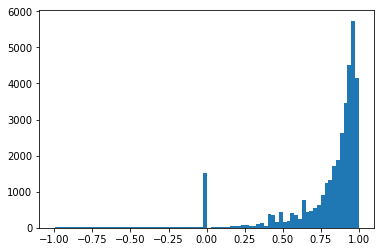

In [154]:
# sentiment.loc[sentiment["binary sentiment"] == "negative"]
plt.hist(sentiment["raw score"],bins = 80, histtype="stepfilled")

### Further Exploration on Negative Reviews

In [20]:
negative = sentiment.loc[sentiment["binary sentiment"] == "negative"]
cancellation = 0
for review in negative["reviews"]:
    cancellation += "The host canceled this reservation" in review
cancellation/len(negative)


0.40931372549019607

In [21]:
negative.describe()

,raw score
count,2448.000000
mean,-0.183526
std,0.304465
min,-0.998300
25%,-0.318200
50%,0.000000
75%,0.000000
max,0.099200


In [256]:
negative = negative[negative["raw score"]< -0.1]
normalized_neg = normalize_corpus(negative["reviews"])
bow_vectorizer_neg = CountVectorizer()
bow_neg = bow_vectorizer_neg.fit_transform(normalized_neg)
bow_feature_names_neg = bow_vectorizer_neg.get_feature_names()
no_topics_news = 6
lda_news = LatentDirichletAllocation(n_components=no_topics_news, max_iter=100,random_state = 42).fit(bow_neg)
no_top_words_news = 10
topic_words = get_topic_words(vectorizer = bow_vectorizer_neg, 
                              lda_model = lda_news, 
                              n_words = no_top_words_news)
pd.DataFrame(topic_words, 
             columns = ["word_" + str(i) for i in range(no_top_words_news)],
             index = ["Topic_" + str(i) for i in range(len(topic_words))])

,word_0,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8,word_9
Topic_0,room,host,place,work,flat,bed,shower,que,night,us
Topic_1,flat,room,bathroom,bed,place,stay,host,door,dirty,shower
Topic_2,stay,room,apartment,host,us,place,bad,check,day,time
Topic_3,tim,tatiana,hall,significant,active,exterior,nightlife,intersection,reduction,interior


### Further Exploration on Neutral Reviews

In [218]:
neutral = sentiment.loc[sentiment["binary sentiment"] == "neutral"]
normalized_neu = normalize_corpus(neutral["reviews"])
bow_vectorizer_neu = CountVectorizer()
bow_neu = bow_vectorizer_neu.fit_transform(normalized_neu)
bow_feature_names_neu = bow_vectorizer_neu.get_feature_names()
no_topics_news = 6
lda_news = LatentDirichletAllocation(n_components=no_topics_news, max_iter=100,random_state = 42).fit(bow_neu)
no_top_words_news = 10
topic_words = get_topic_words(vectorizer = bow_vectorizer_neu, 
                              lda_model = lda_news, 
                              n_words = no_top_words_news)
pd.DataFrame(topic_words, 
             columns = ["word_" + str(i) for i in range(no_top_words_news)],
             index = ["Topic_" + str(i) for i in range(len(topic_words))])

,word_0,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8,word_9
Topic_0,quick,comfortable,ok,thank,response,bad,night,spot,worth,much
Topic_1,excellent,experience,host,airbnb,thanks,describe,outside,exactly,first,apartment
Topic_2,apartment,room,clean,host,location,need,flat,everything,stay,check
Topic_3,room,bed,like,kind,house,hospitality,nothing,property,area,night
Topic_4,location,good,close,great,price,convenient,station,bus,stop,near
Topic_5,place,stay,london,nice,great,location,walk,good,station,close


In [204]:
neutral.describe()

,raw score
count,4212.000000
mean,0.490355
std,0.128313
min,0.100100
25%,0.421500
50%,0.507000
75%,0.599400
max,0.649400
